In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [4]:
# Set the paths to the input image folders
input_folder = "/content/drive/MyDrive/Final Year Project/X4"
lr_folder = os.path.join(input_folder, 'LOW x4 URban100')
hr_folder = os.path.join(input_folder, 'HIGH x4 URban100')

# Set the desired size of the low-resolution images
lr_size = (256, 256)
hr_size = (256, 256)
# Load the images and preprocess them
train_x = []
train_y = []
test_x = []
test_y = []

for filename in os.listdir(lr_folder):
    if filename.endswith('.png'):
        # Load the low-resolution and high-resolution images
        lr_image = cv2.imread(os.path.join(lr_folder, filename)).astype('float64')
        hr_image = cv2.imread(os.path.join(hr_folder, filename.replace('_LR', '_HR'))).astype('float64')
        
        # Resize the low-resolution image to the desired size
        lr_image = cv2.resize(lr_image, lr_size, interpolation=cv2.INTER_CUBIC)
        hr_image = cv2.resize(hr_image, hr_size, interpolation=cv2.INTER_CUBIC)
        
        #if np.random.random() < 0.8:
        train_x.append(lr_image/255.0)
        train_y.append(hr_image/255.0)

# Convert the training and testing sets to NumPy arrays
train_x1 = np.array(train_x)
train_y1 = np.array(train_y)

In [5]:
# Split the dataset into training and testing sets (80-20 split)
train_x, train_y = train_x1[0:90,:,:,:], train_y1[0:90,:,:,:]
test_x, test_y = train_x1[80:100,:,:,:], train_y1[80:100,:,:,:]

In [10]:
class PSNRCallback(Callback):
    def __init__(self, validation_data):
        super(PSNRCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Predict the validation set using the model
        y_pred = self.model.predict(self.validation_data[0])
        # Calculate PSNR using NumPy
        psnr = tf.image.psnr(self.validation_data[1], y_pred, max_val=1.5)
        # Add PSNR to the logs
        logs = logs or {}
        logs['val_psnr'] = np.mean(psnr)
        print("PSNR: {:.4f}".format(np.mean(psnr)))

# Define the model architecture of SRCNN
model_srcnn = tf.keras.Sequential()
model_srcnn.add(Conv2D(64, (9, 9), padding='same', input_shape=(None, None, 3)))
model_srcnn.add(Activation('relu'))
model_srcnn.add(Conv2D(32, (1, 1), padding='same'))
model_srcnn.add(Activation('relu'))
model_srcnn.add(Conv2D(3, (5, 5), padding='same'))

# Compile the model
model_srcnn.compile(loss='mse', optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True), metrics=["accuracy"])

# Train the model with PSNRCallback
checkpoint = ModelCheckpoint('model_srcnn.h5', monitor='val_loss', save_best_only=True)
psnr_callback = PSNRCallback(validation_data=(test_x, test_y))
hist_srcnn = model_srcnn.fit(train_x, train_y, batch_size=16, epochs=100, validation_data=(test_x, test_y), callbacks=[checkpoint, psnr_callback])

Epoch 1/100
1/1 [==============================] - 0s 59ms/step
PSNR: 10.6236
6/6 [==============================] - 5s 433ms/step - loss: 0.2736 - accuracy: 0.4333 - val_loss: 0.2054 - val_accuracy: 0.4453 - val_psnr: 10.6236
Epoch 2/100
1/1 [==============================] - 0s 26ms/step
PSNR: 13.4064
6/6 [==============================] - 1s 110ms/step - loss: 0.1753 - accuracy: 0.4441 - val_loss: 0.1092 - val_accuracy: 0.4472 - val_psnr: 13.4064
Epoch 3/100
1/1 [==============================] - 0s 28ms/step
PSNR: 16.7140
6/6 [==============================] - 1s 110ms/step - loss: 0.0873 - accuracy: 0.4398 - val_loss: 0.0527 - val_accuracy: 0.4421 - val_psnr: 16.7140
Epoch 4/100
1/1 [==============================] - 0s 32ms/step
PSNR: 17.4850
6/6 [==============================] - 1s 107ms/step - loss: 0.0511 - accuracy: 0.4325 - val_loss: 0.0439 - val_accuracy: 0.4370 - val_psnr: 17.4850
Epoch 5/100
1/1 [==============================] - 0s 26ms/step
PSNR: 18.3240
6/6 [=========

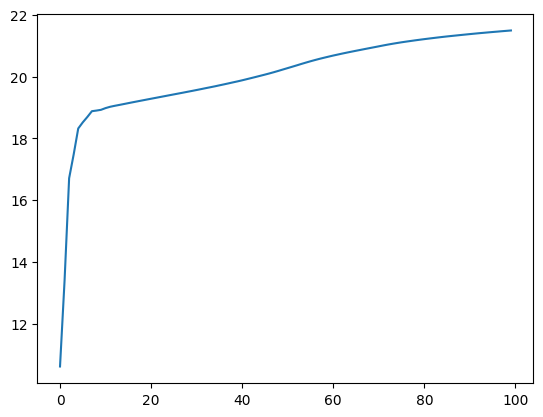

In [11]:
val_psnr = hist_srcnn.history['val_psnr']
x = np.arange(0, 100)
plt.plot(x, val_psnr)

In [24]:
#from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers, models
class PSNRCallback(Callback):
    def __init__(self, X_val, y_val):
        super(PSNRCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
    
    def on_epoch_end(self, epoch, logs=None):
        # Predict the validation set using the model
        y_pred = self.model.predict(self.X_val)
        # Calculate PSNR using NumPy
        psnr = tf.image.psnr(self.y_val, y_pred, max_val=2)
        # Add PSNR to the logs
        logs = logs or {}
        logs['val_psnr'] = np.mean(psnr)
        print("PSNR: {:.4f}".format(np.mean(psnr)))

# Define the VDSR model
def VDSR(input_shape=(None, None, 3)):
    model = models.Sequential()

    # Input layer
    model.add(layers.Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, padding='same', use_bias=False))
    model.add(layers.ReLU())

    # Features trunk blocks
    for _ in range(20):
        model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', use_bias=False))
        model.add(layers.ReLU())

    # Output layer
    model.add(layers.Conv2D(3, kernel_size=(3, 3), padding='same', use_bias=False))

    # Initialize model weights
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            n = layer.kernel_size[0] * layer.kernel_size[1] * layer.filters
            layer.kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=np.sqrt(2.0 / n))

    return model

# Compile the model
model_vdsr = VDSR()
model_vdsr.compile(loss='mse', optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True), metrics=['accuracy'])

# Create the PSNR callback and fit the model
psnr_callback = PSNRCallback(test_x, test_y)
hist_vsdr = model_vdsr.fit(train_x,train_y, batch_size=16, epochs=100, validation_data=(test_x, test_y), callbacks=[psnr_callback])


Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.1250

1/1 [==============================] - 0s 96ms/step
PSNR: 11.8799
6/6 [==============================] - 6s 811ms/step - loss: 0.2855 - accuracy: 0.1250 - val_loss: 0.2728 - val_accuracy: 0.1500 - val_psnr: 11.8799
Epoch 2/100
1/1 [==============================] - 0s 41ms/step
PSNR: 11.8835
6/6 [==============================] - 5s 770ms/step - loss: 0.2853 - accuracy: 0.1254 - val_loss: 0.2726 - val_accuracy: 0.1503 - val_psnr: 11.8835
Epoch 3/100
1/1 [==============================] - 0s 29ms/step
PSNR: 11.8874
6/6 [==============================] - 5s 777ms/step - loss: 0.2850 - accuracy: 0.1267 - val_loss: 0.2724 - val_accuracy: 0.1507 - val_psnr: 11.8874
Epoch 4/100
1/1 [==============================] - 0s 27ms/step
PSNR: 11.8908
6/6 [==============================] - 4s 760ms/step - loss: 0.2848 - accuracy: 0.1267 - val_loss: 0.2722 - val_accuracy: 0.1512 - val_psnr: 11.8908
Epoch 5/100
1/1 [==============================] - 0s 35ms/step
PSNR: 11.8936
6/6 [=====================

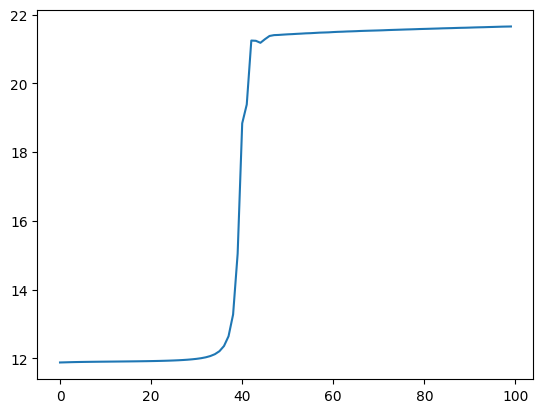

In [25]:
val_psnr = hist_vsdr.history['val_psnr']
x = np.arange(0, 100)
plt.plot(x, val_psnr)

In [26]:
from tensorflow.keras import models, layers

def VDSR_modified1(input_shape=(None, None, 3)):
    model = models.Sequential()

    # Input layer
    model.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', use_bias=False))
    model.add(layers.ReLU())

    # Features trunk blocks
    for _ in range(12):
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', use_bias=False))
        model.add(layers.ReLU())

    # Output layer
    model.add(layers.Conv2D(3, kernel_size=(3, 3), padding='same', use_bias=False))

    # Initialize model weights
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            n = layer.kernel_size[0] * layer.kernel_size[1] * layer.filters
            layer.kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=np.sqrt(2.0 / n))

    return model

# Compile the model
modified_vdsr1 = VDSR_modified1()
modified_vdsr1.compile(loss='mse', optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True), metrics=['accuracy'])

# Create the PSNR callback and fit the model
psnr_callback = PSNRCallback(test_x, test_y)
modified_vsdr1 = modified_vdsr1.fit(train_x,train_y, batch_size=16, epochs=100, validation_data=(test_x, test_y), callbacks=[psnr_callback])

Epoch 1/100
1/1 [==============================] - 0s 80ms/step
PSNR: 11.8728
6/6 [==============================] - 5s 506ms/step - loss: 0.2861 - accuracy: 0.4804 - val_loss: 0.2733 - val_accuracy: 0.4529 - val_psnr: 11.8728
Epoch 2/100
1/1 [==============================] - 0s 26ms/step
PSNR: 11.8807
6/6 [==============================] - 2s 280ms/step - loss: 0.2857 - accuracy: 0.4920 - val_loss: 0.2728 - val_accuracy: 0.4665 - val_psnr: 11.8807
Epoch 3/100
1/1 [==============================] - 0s 25ms/step
PSNR: 11.8898
6/6 [==============================] - 2s 280ms/step - loss: 0.2851 - accuracy: 0.4871 - val_loss: 0.2722 - val_accuracy: 0.4605 - val_psnr: 11.8898
Epoch 4/100
1/1 [==============================] - 0s 40ms/step
PSNR: 11.8991
6/6 [==============================] - 2s 286ms/step - loss: 0.2845 - accuracy: 0.4795 - val_loss: 0.2717 - val_accuracy: 0.4491 - val_psnr: 11.8991
Epoch 5/100
1/1 [==============================] - 0s 37ms/step
PSNR: 11.9084
6/6 [=========

In [ ]:
val_psnr1 = modified_vsdr1.history['val_psnr']
x = np.arange(0, 100)
plt.plot(x, val_psnr1)

In [ ]:
srcnn_psnr = hist_srcnn.history['val_psnr']
vsdr_psnr = hist_vsdr.history['val_psnr']
modified_vsdr1 = modified_vsdr1.history['val_psnr']

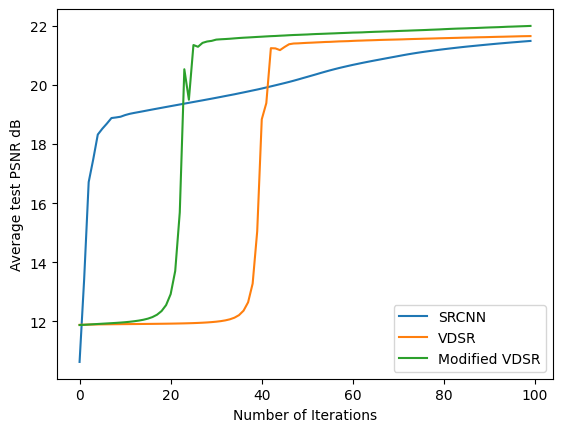

In [49]:
plt.plot(x, srcnn_psnr, label='SRCNN')
plt.plot(x, vsdr_psnr, label='VDSR')
plt.plot(x, modified_vsdr1, label='Modified VDSR')
plt.xlabel('Number of Iterations')
plt.ylabel('Average test PSNR dB')
plt.legend()
plt.savefig('Output_curve.pdf')

In [34]:
np.savez_compressed('plot_record.npz', srcnn_psnr, vsdr_psnr, modified_vsdr1)
np.savez_compressed('All_data.npz', srcnn_psnr, vsdr_psnr, modified_vsdr1, model_srcnn, model_vdsr, modified_vdsr1)

In [ ]:
def VDSR_multi(input_shape=(None, None, 3)):
    model = models.Sequential()
    
    # Multiscale inputs
    inputs = []
    for scale in [2, 3, 4]:
        inp = layers.Input(shape=(None, None, 3))
        inputs.append(inp)
        x = layers.Lambda(lambda z: tf.image.resize(z, size=(tf.shape(z)[1]//scale, tf.shape(z)[2]//scale), method='bicubic'))(inp)

        # Input layer
        x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = layers.ReLU()(x)

        # Features trunk blocks
        for _ in range(8):
            x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', use_bias=False)(x)
            x = layers.ReLU()(x)

        # Output layer
        x = layers.Conv2D(3, kernel_size=(3, 3), padding='same', use_bias=False)(x)

        # Output upscaling
        x = layers.Lambda(lambda z: tf.image.resize(z, size=(tf.shape(z)[1]*scale, tf.shape(z)[2]*scale), method='bicubic'))(x)
        model.add(models.Model(inputs=inp, outputs=x))
        
    return model

# Compile the model
multi_vdsr = VDSR_multi()
multi_vdsr.compile(loss='mse', optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True), metrics=['accuracy'])

# Train the model
hist_multi = multi_vdsr.fit([train_x]*3, train_y, batch_size=32, epochs=10, validation_data=([test_x]*3, test_y))


In [ ]:
srcnn_out = model_srcnn.predict(test_x)
vsdr_out = model_vdsr.predict(test_x)
modified_vsdr = modified_vdsr1(test_x)

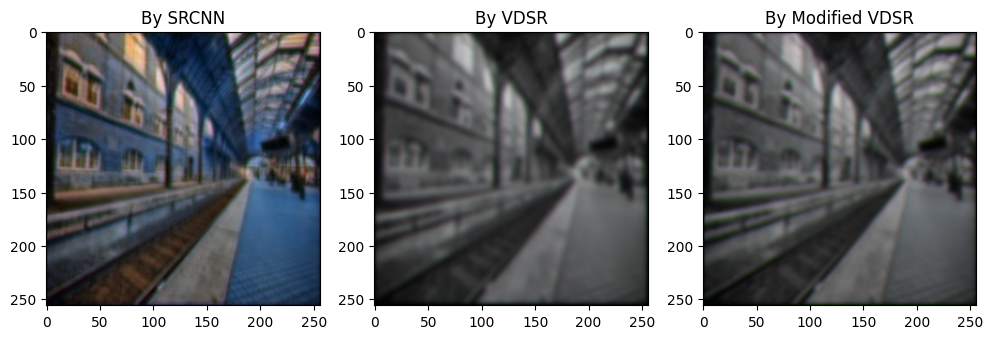

In [47]:
i = 8
plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.imshow(srcnn_out[i])
plt.title('By SRCNN')

plt.subplot(1,3,2)
plt.imshow(vsdr_out[i])
plt.title('By VDSR')

plt.subplot(1, 3, 3)
plt.imshow(modified_vsdr[i])
plt.title('By Modified VDSR')
plt.savefig('Super_resolved.pdf')